In [1]:
source('./processing_scripts/util.R')
source('plot_scripts/plot_fns.R')
source('./processing_scripts/make_fmat.R')

tag="MCF10A"
library('ggplot2')
library('data.table')
library('cowplot')
options(warn=-1) # turn off warnings

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked _by_ ‘.GlobalEnv’:

    %+%


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
proc_data = function(dm){
    ddir = './processed_data/'%+%tag%+%"/csv/"
    dir(ddir)
    d = read.csv(ddir%+%tag%+%"_"%+%dm%+%"_df.csv",row.names=1)
    d = data.table(d)
    d$PlateWell <- d$Plate%+%"."%+%d$Well
    
    numeric_cols = colnames(d)[71:ncol(d)-3][-(180:184)]
    numeric_cols = numeric_cols[which(sapply(numeric_cols,function(s)grepl("_RR$|_RR_ADJ$",s)))]
    texture_cols = numeric_cols[grepl("Texture",numeric_cols)]
    non_texture = setdiff(numeric_cols,texture_cols)                                         
                                         
    d = d[ , (numeric_cols) := lapply(.SD, function(x)x-mean(x,na.rm=TRUE)), .SDcols = numeric_cols,by=.(PlateWell)]
                                      
    fmats = lapply(names(d),function(v)make_fmat(d,v))
    names(fmats) <- names(d)
                       
    return(list(d=d,fmats=fmats))
}

In [3]:
d_adj_seq = c(0,1,2,3,5,7,10,15,25)

In [4]:
data_list = lapply(d_adj_seq,proc_data)

In [5]:
pca_plt = function(fmats,dm=NULL){
    ft = "Nuclei_PA_Cycle_DNA2NProportion_RR"
    svd1_adj = memanorm::average_svd_na(fmats[ft%+%"_ADJ"])
    
    hl="THBS1_1"
    sctr_thbs1 = asvd_scatter(svd1_adj,fmats,k=2,hl=hl,ttl=paste0('d=',dm),legnd=TRUE)
    return(sctr_thbs1)
}

In [6]:
plts = lapply(seq_along(data_list),function(i)pca_plt(data_list[[i]]$fmats,d_adj_seq[i]))

In [7]:
plts = lapply(plts,'[[',1)

In [8]:
leg = get_legend(plts[[1]])

In [9]:
plts_nol = lapply(plts,function(x)x+guides(color="none",shape="none"))

In [10]:
p_d = plot_grid(plotlist=plts_nol,nrow=3,labels=paste0('(',LETTERS[1:7],')'))

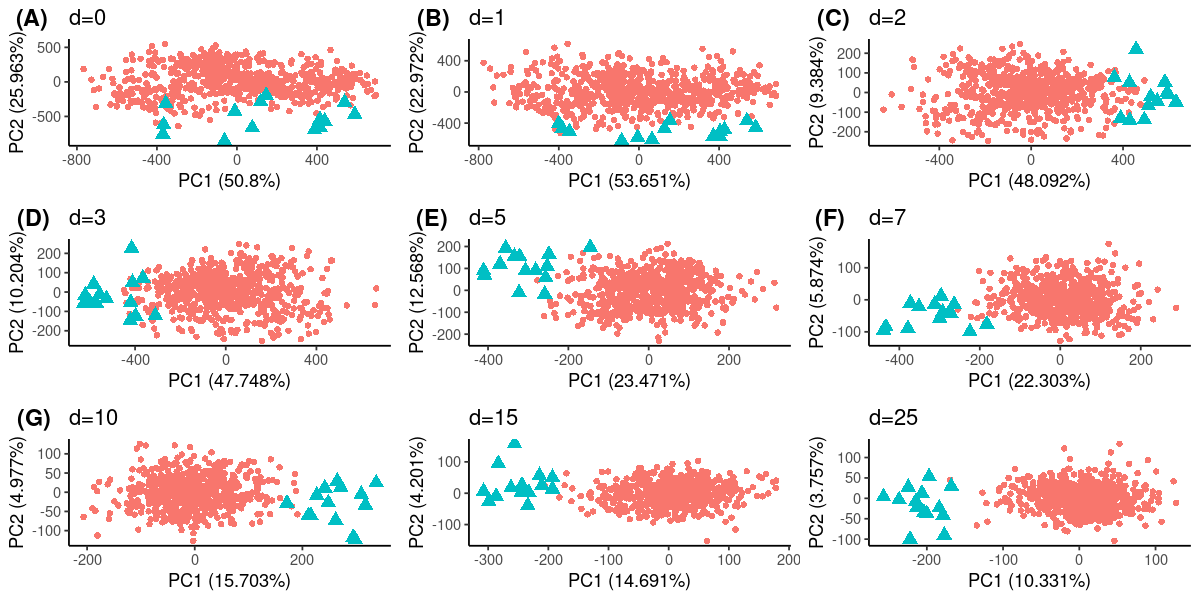

In [11]:
options(repr.plot.width = 10, repr.plot.height = 5)
p_d

In [12]:
ggsave(plot=p_d,file='ds.pdf',width=15,height=8)